In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plotdir = 'plots/'

# Plots

## locations

In [32]:
ids = []
ids_file='../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid.samples' %1
with open(ids_file, mode='r') as file:
    next(file); next(file) #skip header and 0 row
    for line in file: 
        ids.append(line.strip().split(' ')[0])

metadata = []
with open('../data/66_genomes_summary.txt','r') as file:
    next(file) #skip header
    for line in file:
        metadata.append(line.strip().split('\t'))
        
accessions = [i[1].strip().replace('_','.').split('.')[0].replace('"','') for i in metadata]
accessions2 = [i[3] for i in metadata]

order = []
for id in ids:
    try:
        ix = accessions.index(id)
    except:
        ix = accessions2.index(id)
    order.append(ix)

group = np.array([i[2] for i in metadata])[order]
population_names, population_ixs = np.unique(group, return_inverse=True)

locations = np.array([list(map(float,[i[7].replace(',','.'),i[6].replace(',','.')])) for i in metadata])[order]
# locations = np.load('../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_locations.npy')

In [28]:
fig = go.Figure(data = px.scatter_geo(lon=locations[:,0],
                                      lat=locations[:,1], 
                                      color=group, 
                                      hover_name=ids, 
                                      fitbounds='locations', projection="natural earth"))

fig.update_layout(
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
#         projection = dict(
#             type = 'conic conformal',
#             rotation_lon = meanlon
#         ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ min(locations[:,0]), max(locations[:,0]) ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ min(locations[:,1]), max(locations[:,1]) ],
            dtick = 5
        )
    ),
    legend=dict(
    yanchor="bottom",
    y=0,
    xanchor="left",
    x=0.3,
    bgcolor='rgba(0,0,0,0)',
#     bordercolor="Black",
#     borderwidth=1
    ),
    legend_title_text=''
)
fig.show()
fig.write_image(plotdir + 'locations.png')

## dispersal rates

In [26]:
Ne = 1e5 #prior Ne
m = '7e-9' #prior mutation rate
numiter = 10 #number of MCMC iterations in estimating Ne
threshold = 0.5 #fraction of trees to drop when estimating Ne
nsamples = 1000 #number of trees per locus
fname = '../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
fname = fname %(Ne, m, numiter, threshold) + '_1000nsamples_%stCutoff_mle-dispersal.npy'

In [27]:
tCutoffs = ['None',int(1e6),int(1e5),int(1e4)]

In [30]:
mles = []
for T in tCutoffs:
    mle = np.load(fname %T, allow_pickle=True)
    mles.append(mle)

In [33]:
meanlon = np.mean(locations[:,0])

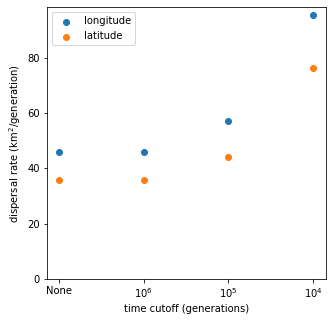

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(range(len(mles)), [mle[0]**2 * 110**2 for mle in mles], label='longitude')
ax.scatter(range(len(mles)), [mle[1]**2 * (np.cos(meanlon * np.pi/180)*111)**2 for mle in mles], label='latitude')

xticks = range(len(mles))
xlabels = ['None', '$10^6$', '$10^5$', '$10^4$']
plt.xticks(xticks, xlabels)
plt.xlabel('time cutoff (generations)')

ax.set_ylim(ymin=0)
ax.set_ylabel(r'dispersal rate ($\mathrm{km}^2/\mathrm{generation}$)')
ax.legend()
    
# plt.savefig(plotdir + 'dispersal-rates.png')
plt.show()